# Titanic competion

This notebook builds a predictive model for answer the question: "what sorts of people were more likely to survive at the Titanic?" using passenger data, as defined by the [Kaggle's Titanic competition](https://www.kaggle.com/c/titanic).

In [56]:
# Load dependencies.
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## 1. Load and clear data

In [57]:
# Load train and test data.
test_data_raw = pd.read_csv('./data/test.csv', sep=',')
train_data_raw = pd.read_csv('./data/train.csv', sep=',')

# Take a quick look into the data.
train_data_raw.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [58]:
# Remove useless columns fill missing age values with mean.
train_data = train_data_raw.drop(['Cabin', 'Fare', 'Name', 'Ticket'], axis=1)
train_data = train_data.fillna(train_data.mean())

## 2. Explore data

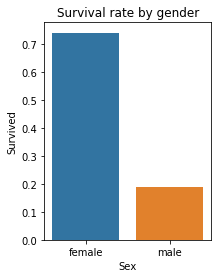

In [59]:
# Calculate survival rate by gender.
gender_rate = train_data[['Sex', 'Survived']].groupby('Sex').mean()

# Draw bar chart.
plt.figure(figsize=(3,4))
plt.title("Survival rate by gender")
sns.barplot(x=gender_rate.index, y=gender_rate['Survived'])

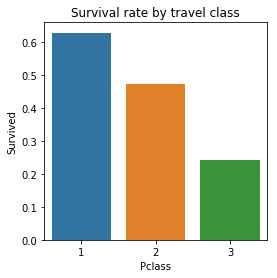

In [60]:
# Calculate survival rate by travel class.
class_rate = train_data[['Pclass', 'Survived']].groupby('Pclass').mean()

# Draw bar chart.
plt.figure(figsize=(4,4))
plt.title("Survival rate by travel class")
sns.barplot(x=class_rate.index, y=class_rate['Survived'])

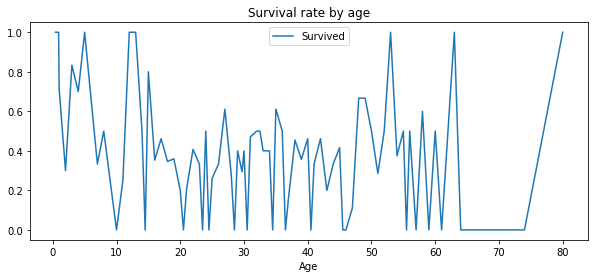

In [61]:
# Calculate survival rate by age.
age_rate = train_data[['Age', 'Survived']].groupby('Age').mean()

# Draw line chart.
plt.figure(figsize=(10,4))
plt.title("Survival rate by age")
sns.lineplot(data=age_rate)

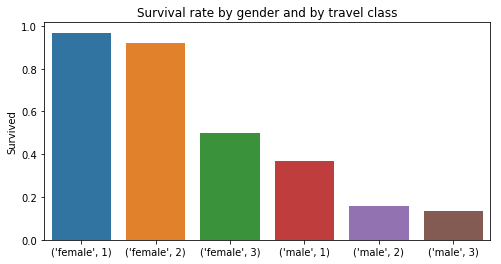

In [62]:
# Calculate survival rate by gender and travel class.
gender_class_rate = train_data[['Sex', 'Pclass', 'Survived']].groupby(['Sex', 'Pclass']).mean()

# Draw bar chart.
plt.figure(figsize=(8,4))
plt.title("Survival rate by gender and by travel class")
sns.barplot(x=gender_class_rate.index, y=gender_class_rate['Survived'])

## 3. Build models

### 3.1 Handcrafted models

In [63]:
# Make a model in which all men died and all women survived.
pred_survived = pd.Series(0, index=train_data.index)
pred_survived[
  train_data[train_data.Sex == 'female'].index
] = 1

accuracy_score(y_true = train_data['Survived'], y_pred = pred_survived)

0.7867564534231201

In [64]:
# Make a model in which only whealty women survived.
pred_survived = pd.Series(0, index=train_data.index)
pred_survived[
  train_data[(train_data.Sex == 'female') & (train_data.Pclass <= 2)].index
] = 1

accuracy_score(y_true = train_data['Survived'], y_pred = pred_survived)

0.7867564534231201

In [65]:
# Make a model following the 'women and children first' code of conduct.
pred_survived = pd.Series(0, index=train_data.index)
pred_survived[
  train_data[(train_data.Sex == 'female') | (train_data.Age <= 8)].index
] = 1

accuracy_score(y_true = train_data['Survived'], y_pred = pred_survived)

0.7934904601571269

### 3.2 Decision tree and forest models

In [66]:
# Separate output from input columns.
X = train_data.drop('Survived', axis=1)
y = train_data['Survived'].copy()

# Convert categorical values into indicator variables.
X = pd.get_dummies(X)

# Separate data into training and testing subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

In [67]:
# Create and train a classifier using a decision tree.
titanic_tree_classifier = DecisionTreeClassifier(max_leaf_nodes=7, random_state=0)
titanic_tree_classifier.fit(X_train, y_train)

# Make predictions.
y_pred_dt = titanic_tree_classifier.predict(X_test)

# Check the accuracy of the decision tree predictions.
accuracy_score(y_true = y_test, y_pred = y_pred_dt)

0.8033898305084746

In [68]:
# Create and train a classifier using a random forest.
titanic_forest_classifier = RandomForestClassifier(n_estimators=3, max_leaf_nodes=4, random_state=324)  
titanic_forest_classifier.fit(X_train, y_train)

# Make predictions (again).
y_pred_rf = titanic_forest_classifier.predict(X_test)

# Check the accuracy of the random forest predictions.
accuracy_score(y_true = y_test, y_pred = y_pred_rf)

0.7898305084745763

## 4. Make predictions

In [69]:
# Make the predictions using the descision tree.
test_data = test_data_raw.drop(['Cabin', 'Fare', 'Name', 'Ticket'], axis=1)
test_data = test_data.fillna(test_data.mean())
test_data = pd.get_dummies(test_data)

tree_test_predictions = titanic_tree_classifier.predict(test_data)

# Generate the submission file (to be uploaded to Kaggle).
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': tree_test_predictions})
output.to_csv('my_submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!
